In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.optim import SGD

import matplotlib.pyplot as plt

In [ ]:
class BasicNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.w00 = nn.Parameter(torch.tensor(1.7), requires_grad=False)
        self.b00 = nn.Parameter(torch.tensor(-0.85), requires_grad=False)
        self.w01 = nn.Parameter(torch.tensor(-40.8), requires_grad=False)

        self.w10 = nn.Parameter(torch.tensor(12.6), requires_grad=False)
        self.b10 = nn.Parameter(torch.tensor(0.0), requires_grad=False)
        self.w11 = nn.Parameter(torch.tensor(2.7), requires_grad=False)

        self.final_bias = nn.Parameter(torch.tensor(-16.0), requires_grad=True)

    def forward(self, input):
        input_to_top_relu = input * self.w00 + self.b00
        top_relu_output = F.relu(input_to_top_relu)
        scaled_top_relu_output = top_relu_output * self.w01

        input_to_bottom_relu = input * self.w10 + self.b10
        bottom_relu_output = F.relu(input_to_bottom_relu)
        scaled_bottom_relu_output = bottom_relu_output * self.w11

        input_to_final_relu = scaled_top_relu_output + scaled_bottom_relu_output + self.final_bias

        return F.relu(input_to_final_relu)

In [30]:
model = BasicNN()

In [35]:
inputs = torch.tensor([0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0])
labels = torch.tensor([0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0])

optimizer = SGD(model.parameters(), lr=0.1)
total_loss = 0.0
for epoch in range(100):
    total_loss = 0
    for i in range(len(inputs)):
        input_i = inputs[i]
        label_i = labels[i]
        output_i = model(input_i)
        loss = (label_i - output_i) ** 2
        loss.backward()
        total_loss += float(loss)
    
    if total_loss < 0.0001:
        print("Num steps: ", epoch)
        print("Total loss: ", total_loss, "\n======")
        break
    
    optimizer.step()
    optimizer.zero_grad()
    print("Step: ", epoch)
    print("Total loss: ", total_loss)
    print("Bias value: ", model.final_bias.data, "\n======") 

Num steps:  0
Total loss:  1.4551915228366852e-11 


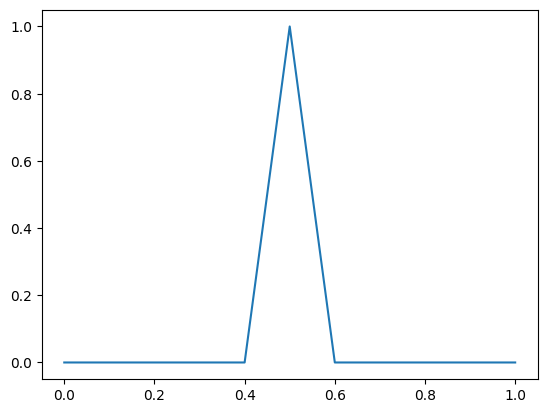

In [36]:
final_outputs = model(inputs)
plt.plot(inputs, final_outputs.detach())

## LSTM

In [2]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt

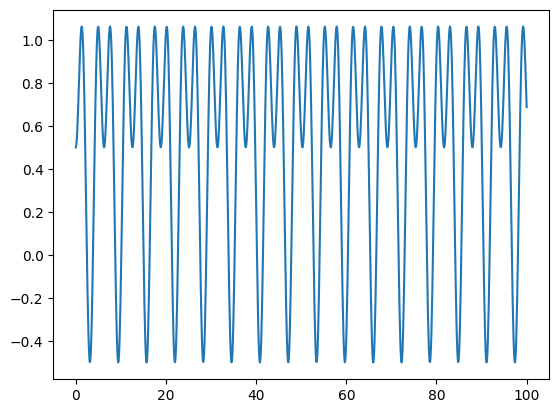

In [145]:
x_start, x_end = 0, 100
n_samples = 1000
noise = 0.0

x = np.linspace(x_start, x_end, num=n_samples)
y = np.sin(x) ** 2 + 0.5 * np.cos(x) + np.random.normal(loc=0, scale=noise, size=n_samples)
plt.plot(x, y)

In [146]:
class LSTMModel(nn.Module):
    def __init__(self, input_size=1, hidden_size=50, output_size=1, num_layers=1):
        super(LSTMModel, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        out, _ = self.lstm(x)
        out = self.fc(out)
        return out

In [147]:
lstm = LSTMModel(input_size=1, hidden_size=50, output_size=1, num_layers=1)

In [148]:
# Prepare the data
xs = []
ys = []

for i in range(len(y) - 1):
    xs.append(y[i])
    ys.append(y[i + 1])

xs = np.array(xs).reshape(-1, 1)
xs = torch.tensor(xs, dtype=torch.float32)

ys = np.array(ys).reshape(-1, 1)
ys = torch.tensor(ys, dtype=torch.float32)

In [149]:
# Train the model
criterion = nn.MSELoss()
optimizer = optim.Adam(lstm.parameters(), lr=0.01)
num_epochs = 100
for epoch in range(num_epochs):
    lstm.train()
    optimizer.zero_grad()
    
    # Forward pass
    y_hat = lstm(xs)
    loss = criterion(y_hat, ys)

    # Backward pass and optimization
    loss.backward()
    optimizer.step()

    if (epoch + 1) % 10 == 0:
        print(f'Epoch [{epoch + 1}/{num_epochs}], Loss: {loss.item():.4f}')

Epoch [10/100], Loss: 0.1374
Epoch [20/100], Loss: 0.0296
Epoch [30/100], Loss: 0.0082
Epoch [40/100], Loss: 0.0012
Epoch [50/100], Loss: 0.0009
Epoch [60/100], Loss: 0.0005
Epoch [70/100], Loss: 0.0004
Epoch [80/100], Loss: 0.0004
Epoch [90/100], Loss: 0.0004
Epoch [100/100], Loss: 0.0003


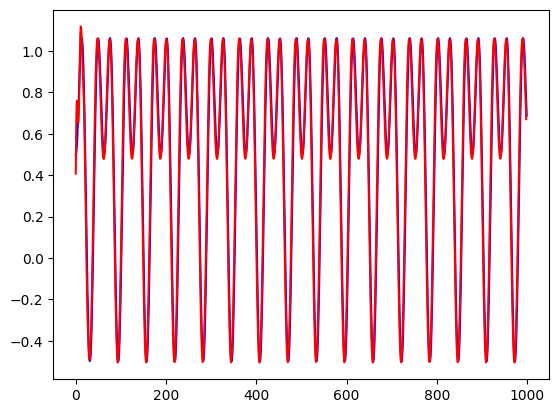

In [150]:
# Fitted values
lstm.eval()
with torch.no_grad():
    y_hat = lstm(xs)
y_hat = y_hat.numpy()

plt.plot(np.arange(len(y)), y, label='Original values', color='blue')
plt.plot(np.arange(len(y_hat)), y_hat, label='Fitted values', color='red')

In [ ]:
# https://www.youtube.com/watch?v=RHGiXPuo_pI
# fast ai book
# article on LSTMs, RNNs, and GRUs

### Going further

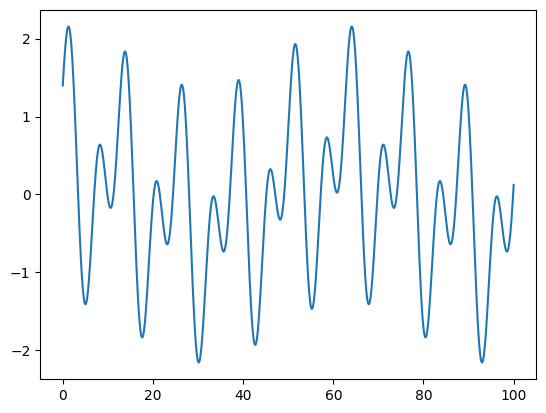

In [ ]:
# Predict next value based on the last 10 values
x_start, x_end = 0, 100
n_samples = 1000
noise = 0.0

x = np.linspace(x_start, x_end, num=n_samples)
y = np.sin(x) + np.cos(0.5 * x) + 0.4 * np.cos(0.1 * x)
plt.plot(x, y)

In [164]:
xs, ys = [], []
for i in range(len(y) - 10):
    xs.append(y[i:i + 10])
    ys.append(y[i + 10])

xs = np.array(xs).reshape(-1, 10)
xs = torch.tensor(xs, dtype=torch.float32)

ys = np.array(ys).reshape(-1, 1)
ys = torch.tensor(ys, dtype=torch.float32)

In [185]:
# Using torch data loader
from torch.utils.data import DataLoader, TensorDataset
dataset = TensorDataset(xs, ys)
dataloader = DataLoader(dataset, batch_size=32)